# Datacube product metadata and database initialisation
---

## How to run docker-compose to setup docker envionment
Go to `crop-mask/production/dea_ml` folder and run 
```bash
docker-compose up
```
to start the docker dev environment. Then, in other terminal window run 
```bash
docker exec -it dea_ml_stats_1 /bin/bash
```
---

## Open datacube dev environment setup

The original open datacube tutorial has the [database setup](https://datacube-core.readthedocs.io/en/latest/ops/db_setup.html) initialisation steps.

Here, we will run `docker-compose up` in the `crop-mask/production/dea_ml` for the open datacube database. The `docker-compose` will start two containers,

- postgresql, the database for the 
- stats

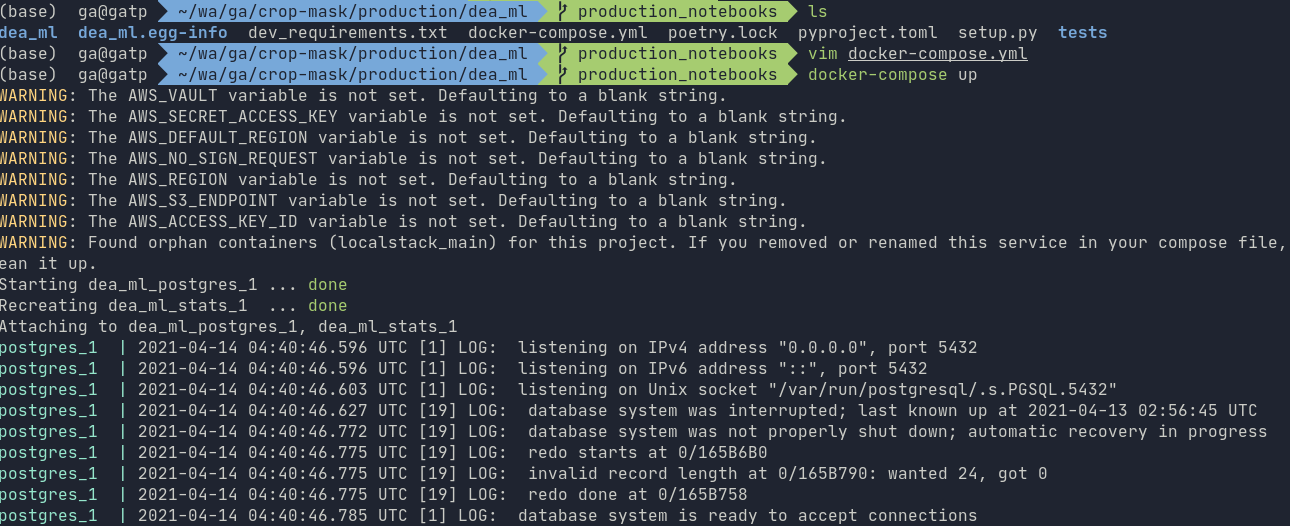


We can check the docker container running status with `docker ps`. 

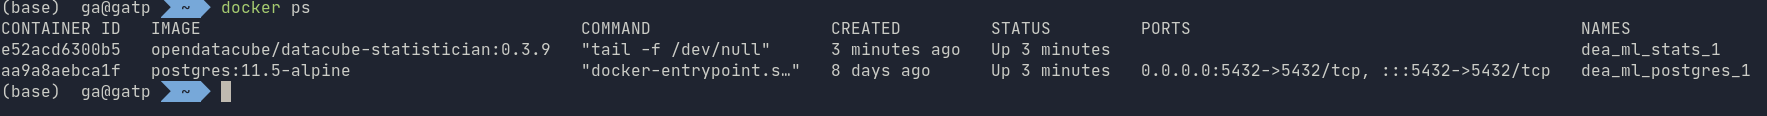

In new terminal, we run,
```bash
docker exec -it dea_ml_stats_1 /bin/bash
```
to get into the container and run the following commands to initialise the testing database.


1. ```createdb datacube```
   or
   ```createdb -h <hostname> -U <username> datacube```

2. ```datacube -v system init```

  After the datacube system initialisation, we can have the database with the following structure
  
  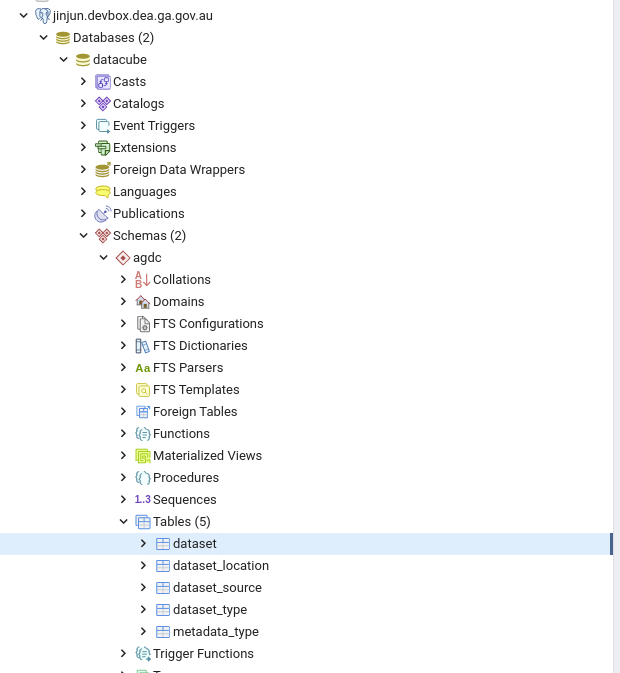
  
  <!--- <img src="../figs/datacube-steps/create_db_sys_init.png"> --->

3. In the local dev envrionment, Python class ```Datacube``` will look for a configuration file in `````~/.datacube.conf`````
which will be edited like sample below

```bash
[datacube]
 db_hostname: localhost
 db_username: postgres
 db_password: opendatacubepassword
```

4. prepare the product meta yaml file and add product into datacube

```bash
datacube product add <product_name>.odc-product.yaml
```
We will have the product meta row in the `dataset_type` table of `agdc` schema inside the `datacube` database.

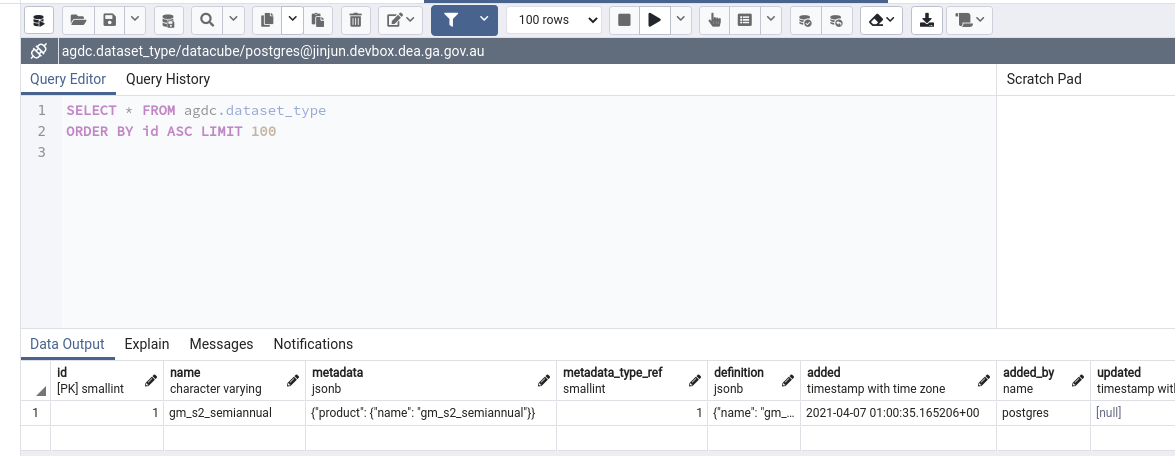

---

## The product yaml
The product yaml will has following fields. And the `metadata` will be picked up as the signature in the code. All the products definition can be found in the [config](https://github.com/digitalearthafrica/config) repo.

The follow is the `crop_mask` product yaml.

```yaml
---
name: crop_mask_eastern
description: Estern Africa region crop mask prediction based on features
   of s2_l2a statistics gm_tmad, plus NDVI, LAI, MNDWI, rainfall, slope
metadata_type: eo3

license: CC-BY-4.0

metadata:
   product:
      name: crop_mask_eastern

storage:
   crs: epsg:6933
   resolution:
      x: 20
      y: -20
   tile_size:
      x: 96000
      y: 96000

measurements:
   - name: mask
     aliases: ['crop_mask', 'MASK']
     dtype: uint8
     nodata: 255
     units: '1'

   - name: prob
     aliases: ['crop_prob', 'PROB']
     dtype: uint8
     nodata: 255
     units: '1'
```

---

## Add product datasets 
The product datasets were described throught the stac json files after run the following commands in k8s dev pods,
- `odc-stats save-tasks ...` 
- `odc-stats publish-tasks ...`

and, run k8s job of the stats-processing, we will have the datasets ready on s3 target bucket.
- the k8s job will run the tasks configured with a command `odc-stats run ...` and its context.

To add datasets into the database for indexing, we can use `s3-to-dc`
- `s3-to-dc 's3://deafrica-data-dev-af/gm_s2_semiannual/0-1-0/**/*.json' 'gm_s2_semiannual' --stac --no-sign-request --skip-lineage` 

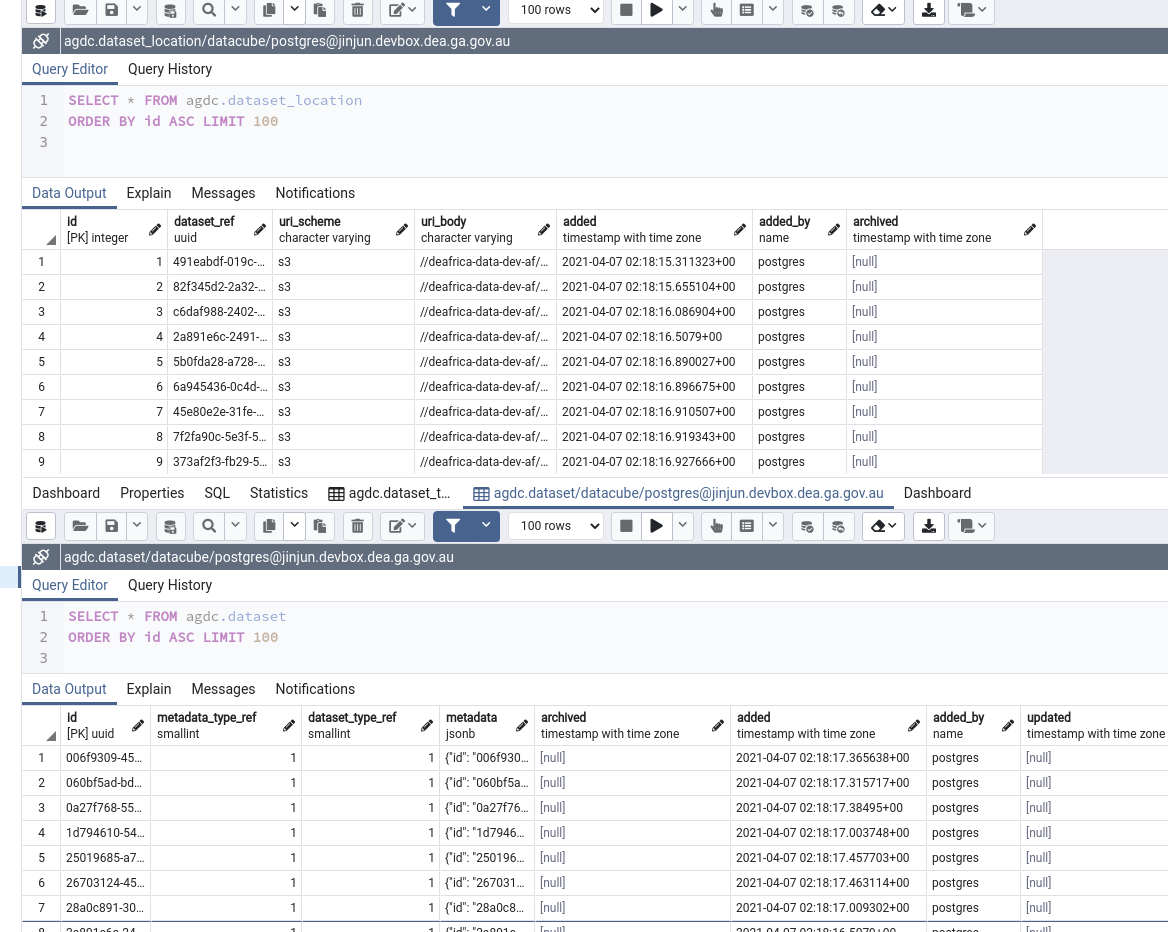

## How to query the indexed datasets
- 2019 semiannual datasets were indexed

In [1]:
import sys
from datacube import Datacube

sys.path.append('../../Scripts')
from deafrica_plotting import rgb

ModuleNotFoundError: No module named 'deafrica_plotting'

In [ ]:
dc = Datacube(app='testing')

In [ ]:
df_product = dc.list_products()
df_product.head()

In [ ]:
all_datasets = list(dc.find_datasets(product='gm_s2_semiannual'))

In [ ]:
bands = ['blue', 'green', 'red', 'nir', 'swir_1']

ds = dc.load(product='gm_s2_semiannual', geopolygon=all_datasets[0].extent, time=('2019-01', '2021-01'), measurements=bands)

ds

In [ ]:
rgb(ds, col='time', col_wrap=2)